<img src="seattle2.webp">

# Projet : Prédire les besoins en consommation de bâtiments de la Ville de Seattle

source image : https://www.flickr.com/photos/sworldguy/15248037137

<b>Compétences évaluées : </b> En tant que data scientist , Ingénieur ML, comprendre le besoin métier Analyser le processus existant et le décrire Identifier les étapes clés où le ML peut être utile Analyser le patrimoine de données et vérifier la faisabilité du projet Explorer et nettoyer les données Entrainer des modèles et mesurer leur performance Vérifier que l'algorithme permet d'optimiser le processus

<b>Projet </b><br>
Mesurer la consommation énergétique d'un bâtiment à partir d'outils de mesure coûte cher. La Ville de Seattle nous commissionne afin de pouvoir évaluer celle ci à partir des caractéristiques de celui-ci.<br>
On doit donc : Prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation à partir de relevés de la ville seattle. <br>

<b>Objectifs </b><br>
Obtenir un modèle pour l'énergie avec un R2 de plus de 0,75 sur le jeu de test et plus de 0,7 pour le CO2.<br>
Les colonnes cibles sont les suivantes : SiteEnergyUseWN(kBtu) & GHGEmissions <br>

<h1 style="margin : 20px"> NoteBook de Modeles/Predictions </h1>

# 0. Import des données /Librairies

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from xgboost import XGBRegressor

In [2]:
%%capture

%run cleaning_marc_final.ipynb ;

# 1.  Predictions : TotalGHGEmissions

In [38]:
# not relevant :  removing \n chars from a copy paste
possible_features_GHG = ['decennie','floor_building', 'is_campus ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical','p_gas','p_steam']
i = 0
while i < len(possible_features_GHG):
    possible_features_GHG[i] = possible_features_GHG[i].strip()
    i+=1

In [39]:
# numpy conversion
X_GHG = ols_df[possible_features_GHG].to_numpy()
y_GHG = ols_df['TotalGHGEmissions'].to_numpy()
# séparation du jeu de train et du jeu de test
X_train_GHG, X_test_GHG , y_train_GHG, y_test_GHG = train_test_split(X_GHG,y_GHG,test_size=0.2, random_state=33)

## 1.1 RandomForest

In [ ]:
# définition du modèle
rf = RandomForestRegressor()
#  param grid !! room to improve the model's "accuracy" 
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)],
           'max_leaf_nodes':[i for i in range(1,10)],
           'random_state':[404,200,42,505]}
# gridsearch cv
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_GHG,y_train_GHG)
# getting params
params = regr.best_params_

In [ ]:
# Prédiction sur le jeu de test 
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'],random_state=505)
final_rf.fit(X_train_GHG,y_train_GHG)
print(metrics.r2_score(y_test_GHG,final_rf.predict(X_test_GHG)))

## 1.2 Régression Linéaire

Standardisation 

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_trainGHG_scaled = sc.fit_transform(X_train_GHG)
X_testGHG_scaled = sc.transform(X_test_GHG)

GridSearchCV

In [49]:
lr = LinearRegression()
param_lr={
    
}
lr = GridSearchCV(lr,param_grid=param_lr,scoring='r2',cv=5,refit=True)
lr.fit(X_trainGHG_scaled,y_train_GHG)
lr.score(X_trainGHG_scaled,y_train_GHG)

0.8667859049625921

Prédiction sur jeu de test

In [50]:
final_lr = LinearRegression()
final_lr.fit(X_trainGHG_scaled,y_train_GHG)
metrics.r2_score(y_test_GHG,final_lr.predict(X_testGHG_scaled))

0.8549486819321901

In [ ]:
res_GHG = pd.DataFrame(y_test_GHG)
res_GHG['preds'] = final_lr.predict(X_testGHG_scaled)
res_GHG['diff'] = res_GHG.apply(lambda x : x['preds'] - x['SiteEnergyUseWNkBtu'] , axis =1 )
plt.scatter(x = res_GHG.index,y = res_GHG['diff'], color='purple')

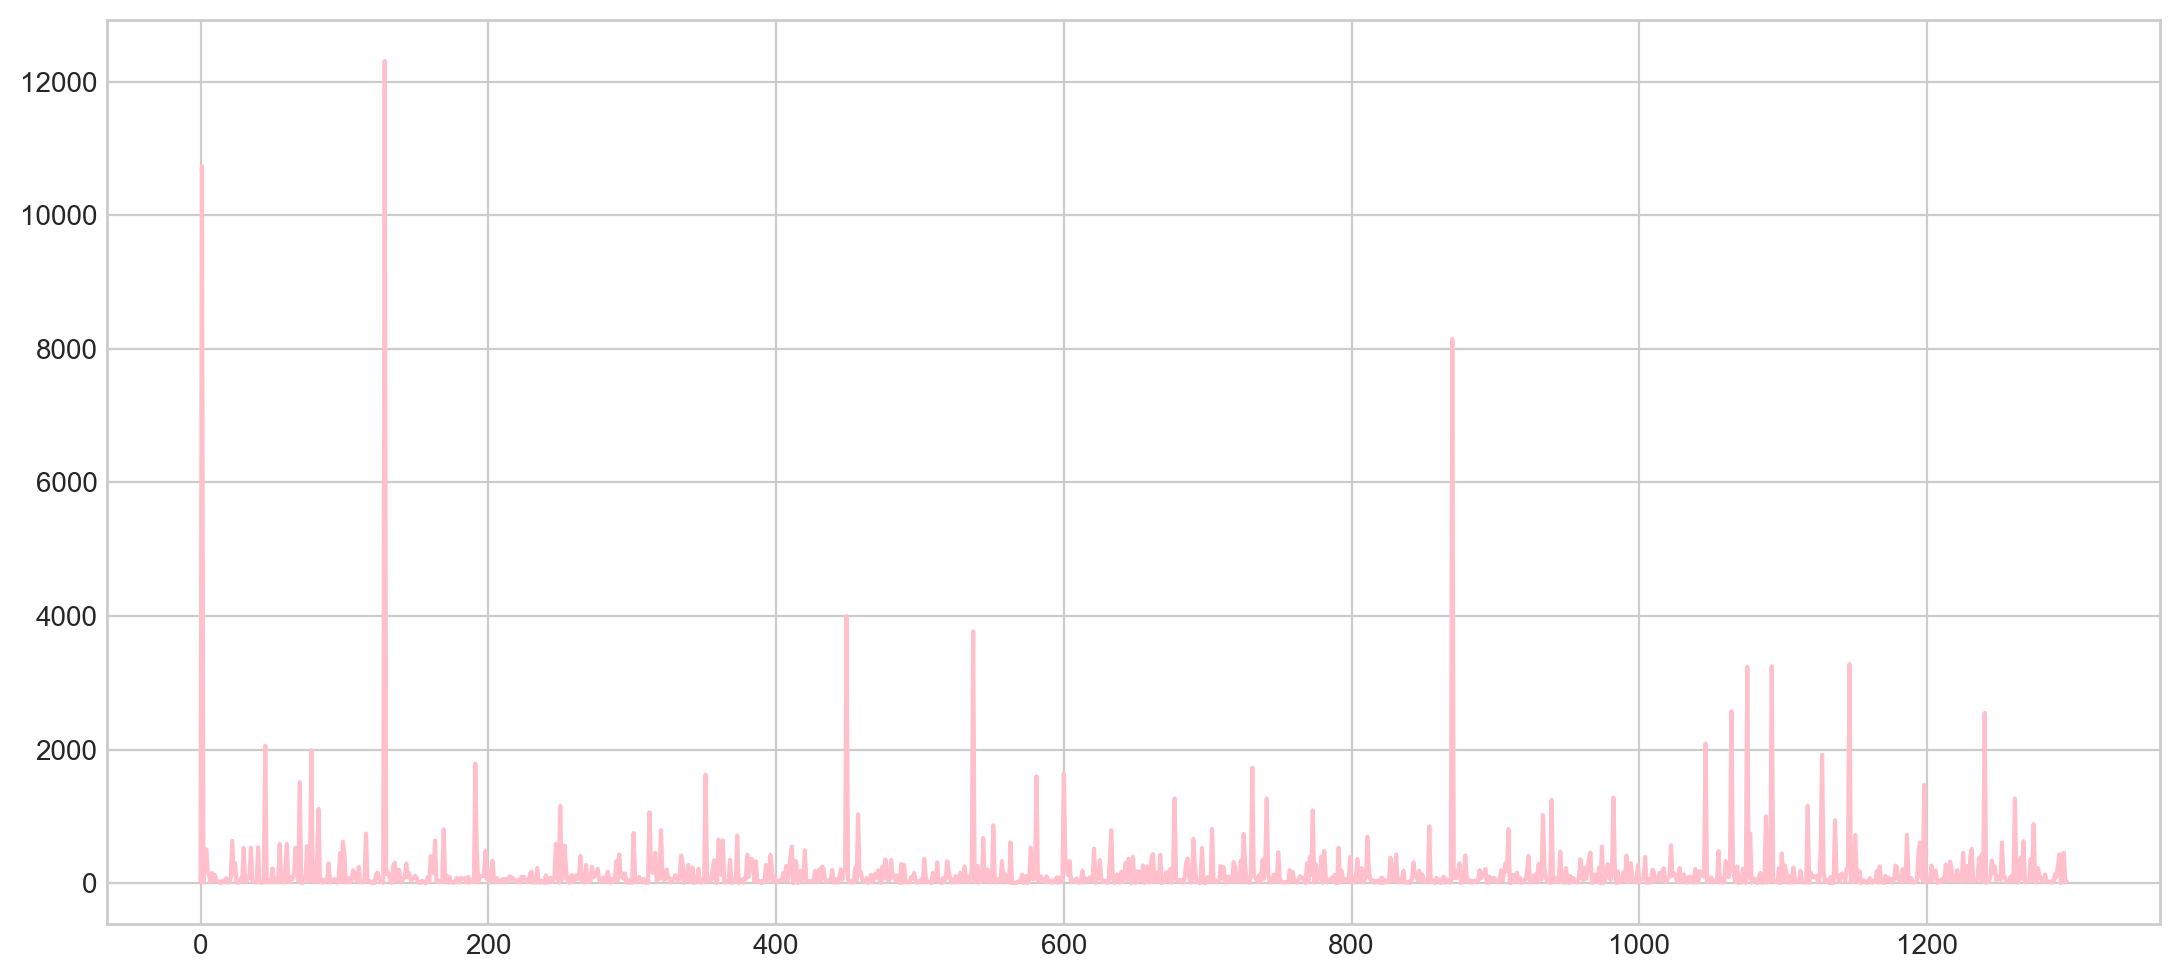

In [46]:
plt.plot(y_train_GHG, color='pink')

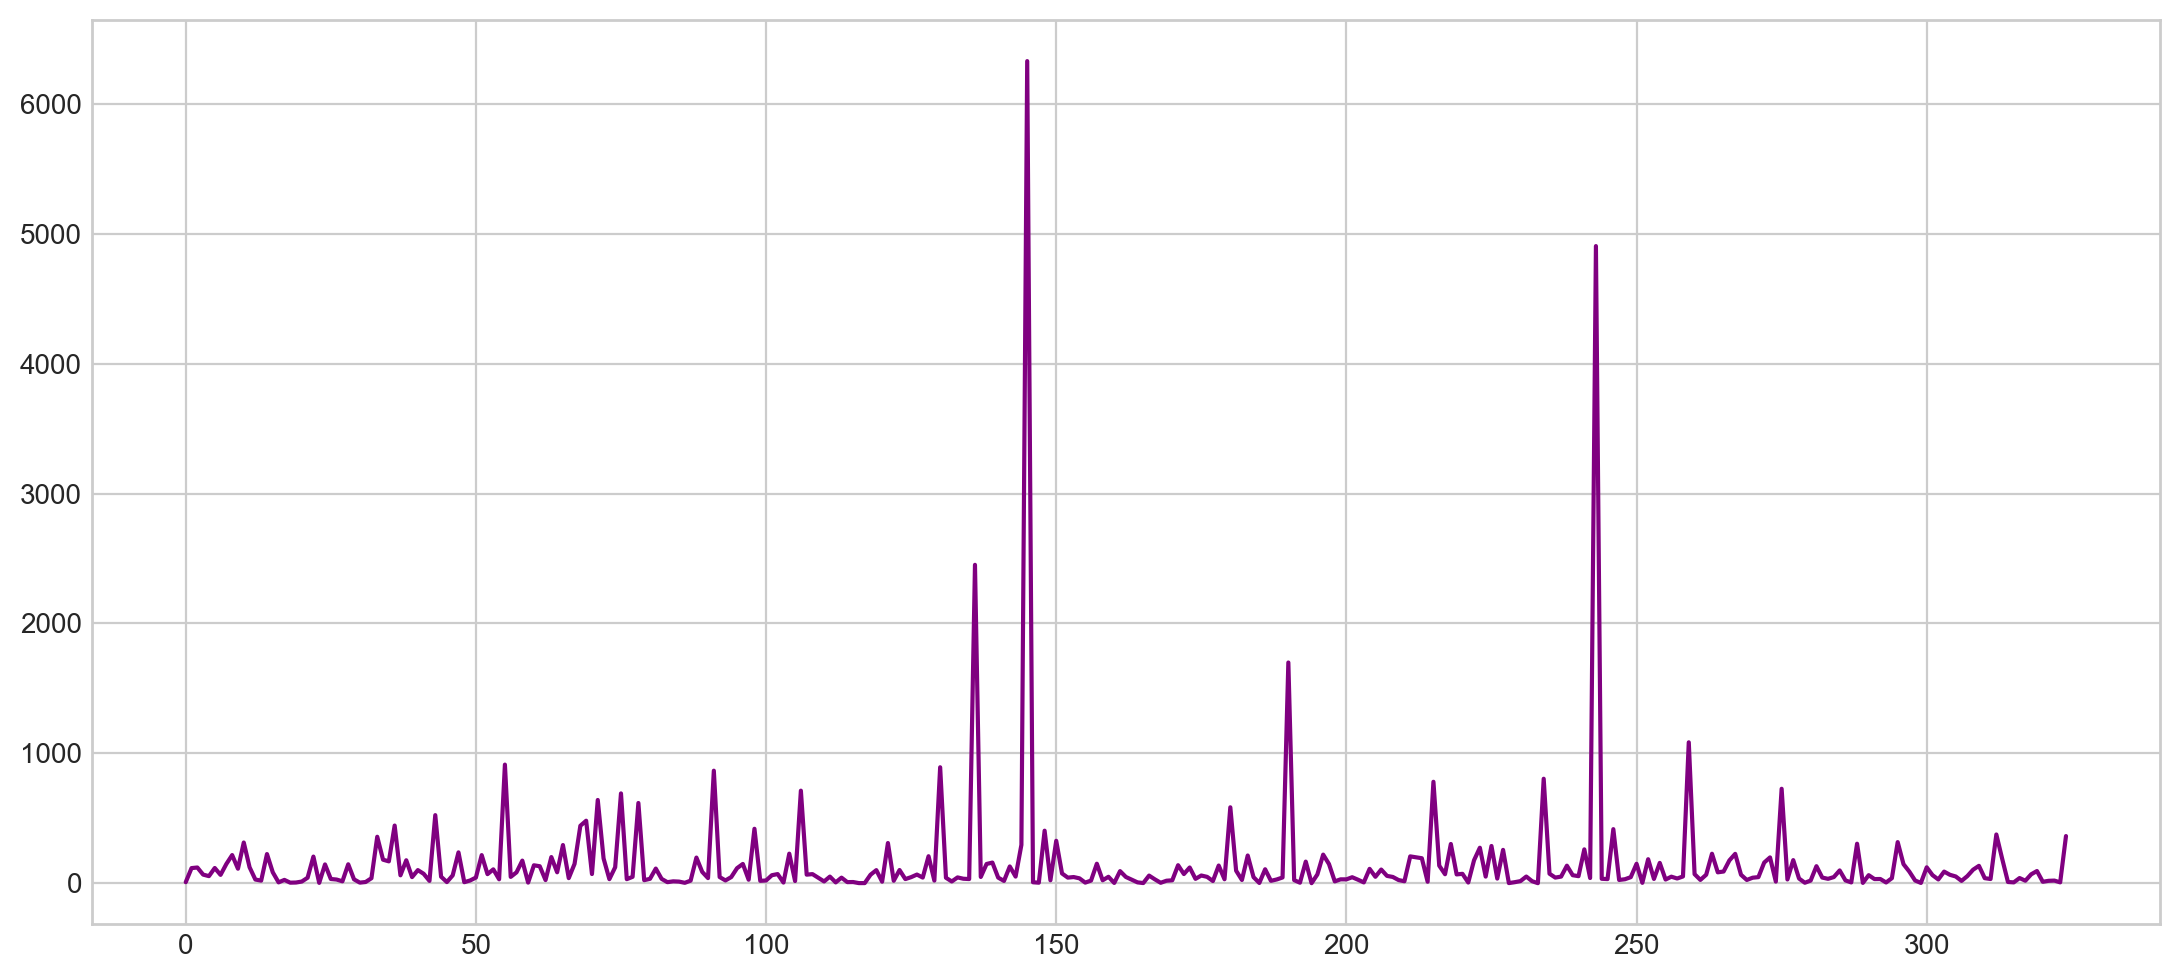

In [44]:
plt.plot(y_test_GHG, color='purple')
plt.show()

# 2.  Prediction : SiteEnergyUsekBtu

In [164]:
# same things as GHG, fixing typo of copy-paste
possible_features_E = ["decennie",'Neighborhood_northeast','floor_building',' is_campus ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall' ]
i = 0 # ' decennie ',
while i < len(possible_features_E):
    possible_features_E[i] = possible_features_E[i].strip()
    i+=1

In [165]:
# définition de la cible
X_energy = ols_df[possible_features_E]
y_energy = ols_df['SiteEnergyUseWNkBtu']

## 2.0 ACP

source code : https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

In [166]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
    
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [168]:
from sklearn.decomposition import PCA
# Scale
X_scaled = (X_energy - X_energy.mean(axis=0)) / X_energy.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(0,X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23
0,-0.215825,-0.044568,-0.208905,0.608642,-0.705296,-0.722668,1.144628,0.225712,0.350867,-1.003528,...,0.187849,0.260706,0.497900,0.127244,-0.132164,-0.203472,0.813452,0.047743,0.052283,-0.121233
1,0.292619,-0.170454,-0.321779,0.267477,0.601875,-0.472813,1.574857,0.399678,0.453287,-0.670296,...,0.311855,-0.106190,0.141362,-0.312115,0.253613,0.001200,-0.778423,-0.092607,0.186742,0.038782
2,5.241283,-0.098501,-0.979963,0.268866,-0.436571,-3.073889,11.272122,2.787560,3.834016,-7.238243,...,1.428854,1.220826,2.747024,-3.989809,0.785379,-2.547747,3.852274,0.191079,-0.914517,0.765677
3,-0.338184,-0.038060,-0.177812,0.587184,-0.703265,-0.619077,0.744377,0.124587,0.215036,-0.745725,...,0.129568,0.221788,0.398261,0.275918,-0.162734,-0.116367,0.680999,0.043341,0.087567,-0.063836
4,0.316474,-0.073735,-0.418079,-0.159888,0.165173,-0.687666,1.850001,0.413403,0.655117,-1.108955,...,0.288447,0.145717,0.476491,-0.546002,0.151750,-0.756710,-0.023722,0.001680,0.130720,-0.038344


In [169]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_energy.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
decennie,-0.180771,0.012830,0.094351,0.434672,-0.483967,-0.091932,-0.102234,-0.031087,-0.070392,-0.125688,...,-0.016414,0.092309,0.081434,0.263552,-0.134627,0.243890,0.560523,0.029307,-0.070387,-0.061036
Neighborhood_northeast,-0.075087,-0.096622,-0.058452,-0.153580,-0.049364,0.636657,0.037131,0.103956,0.025714,-0.105565,...,0.028260,0.084495,0.013795,-0.309197,-0.570937,0.264654,0.052795,0.035862,-0.032699,-0.025037
floor_building,0.672117,0.039034,0.042872,-0.064655,-0.128975,0.019090,0.034269,0.007145,0.009159,-0.022808,...,-0.068172,0.043828,-0.025497,-0.016666,-0.012420,0.053381,0.194179,0.024607,-0.063342,0.684700
is_campus,-0.033519,-0.376414,0.581831,-0.130791,0.015453,-0.001491,0.007460,0.003277,0.009633,0.010012,...,0.002082,-0.018752,-0.017851,-0.038847,0.007490,-0.048940,0.092985,-0.692588,-0.089516,0.002330
Data_Center,0.069999,0.005226,-0.028103,-0.081410,-0.108402,0.002186,-0.112743,-0.112595,-0.027029,0.103831,...,0.927978,-0.068628,0.018546,-0.102760,0.099653,0.051112,0.072494,0.003300,-0.029158,-0.010795
Office,0.656728,0.077914,0.030429,-0.084412,-0.167689,0.042492,-0.152902,-0.067692,-0.041270,0.029230,...,-0.105331,-0.004769,-0.016445,0.069245,-0.039467,0.074058,-0.041854,-0.058327,0.019978,-0.681561
Non_Refrigerated_Warehouse,-0.067017,0.594741,0.340964,-0.027691,0.062971,0.101273,0.022424,0.037710,0.008178,-0.017618,...,0.018391,-0.000154,0.007693,0.014055,-0.006787,-0.029071,-0.099118,0.049851,-0.696248,-0.019076
K_12_School,-0.068682,-0.076639,-0.101883,-0.273730,0.058055,0.206334,0.298399,-0.175866,-0.601534,0.107573,...,-0.107619,-0.081897,-0.099068,-0.059525,0.359332,0.189034,0.292777,0.057200,-0.101804,-0.059206
Retail_Store,0.044460,-0.012081,0.040032,0.329081,0.121293,0.234450,-0.338188,-0.232798,0.030551,-0.149998,...,-0.088381,0.115754,0.476517,-0.472374,0.374301,-0.001870,0.003682,-0.016151,0.019304,0.012459
Other,0.142094,-0.161651,0.161860,0.389214,0.429575,0.173638,-0.034615,0.060215,-0.123946,0.144449,...,0.066797,-0.113987,-0.257611,0.008239,-0.115012,-0.447180,0.348886,0.247932,-0.056688,-0.095211


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

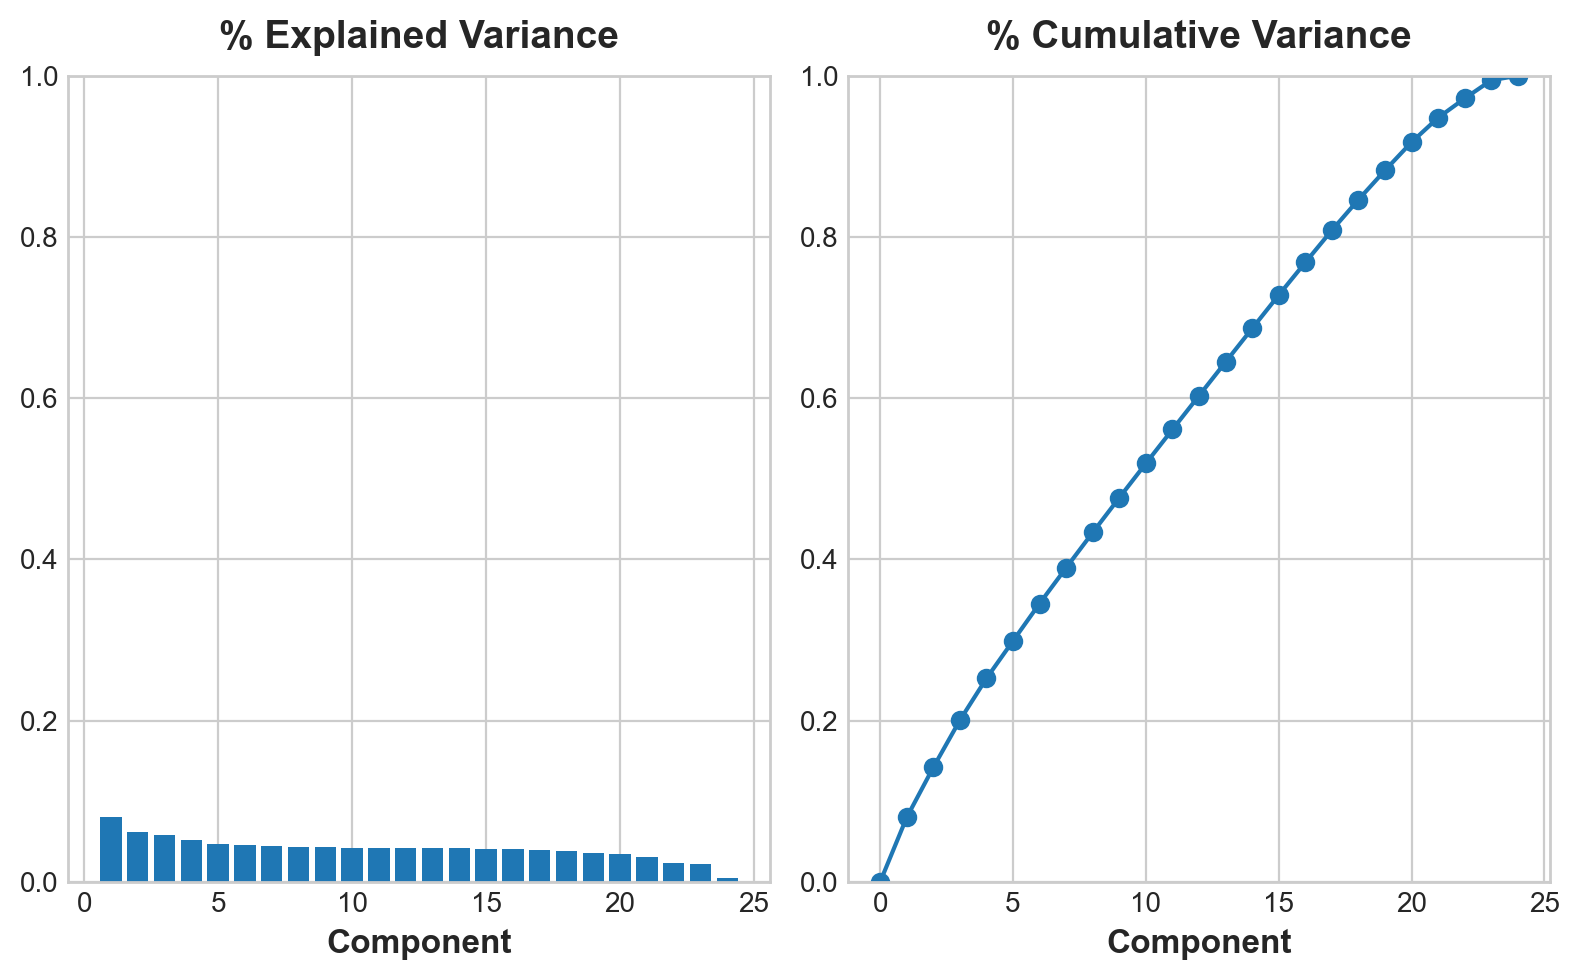

In [170]:
plot_variance(pca)

In [171]:
mi_scores = make_mi_scores(X_pca, y_energy, discrete_features=False)
mi_scores

pca0     0.278850
pca6     0.262580
pca23    0.256438
pca14    0.256237
pca7     0.223136
pca8     0.214334
pca9     0.209834
pca1     0.209215
pca21    0.207515
pca11    0.168847
pca16    0.166613
pca18    0.157638
pca4     0.154369
pca5     0.153128
pca19    0.144352
pca13    0.144216
pca15    0.141204
pca10    0.138010
pca2     0.128156
pca3     0.123610
pca12    0.122100
pca17    0.094719
pca22    0.092535
pca20    0.082823
Name: MI Scores, dtype: float64

In [172]:
# visualisation des coeffs 
loadings.PC1

decennie                                -0.483967
Neighborhood_northeast                  -0.049364
floor_building                          -0.128975
is_campus                                0.015453
Data_Center                             -0.108402
Office                                  -0.167689
Non_Refrigerated_Warehouse               0.062971
K_12_School                              0.058055
Retail_Store                             0.121293
Other                                    0.429575
Hotel                                    0.014183
Distribution_Center                     -0.063273
SupermarketGrocery_Store                 0.290400
Medical_Office                           0.130767
Other___Recreation                      -0.252900
CollegeUniversity                       -0.108762
Other___EntertainmentPublic_Assembly     0.133050
Senior_Care_Community                    0.045410
Laboratory                               0.224691
Restaurant                               0.244399


In [189]:
# ajout de pca14 à X_energy
X_energy['PC0'] =X_pca['pca0'].values
X_energy['PC3'] =X_pca['pca6'].values
X_energy['PC14'] =X_pca['pca14'].values
X_energy.drop(columns=['Data_Center'], inplace =True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3784\433074439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC0'] =X_pca['pca0'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3784\433074439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC3'] =X_pca['pca6'].values


In [173]:
X_energy.columns

Index(['decennie', 'Neighborhood_northeast', 'floor_building', 'is_campus',
       'Data_Center', 'Office', 'Non_Refrigerated_Warehouse', 'K_12_School',
       'Retail_Store', 'Other', 'Hotel', 'Distribution_Center',
       'SupermarketGrocery_Store', 'Medical_Office', 'Other___Recreation',
       'CollegeUniversity', 'Other___EntertainmentPublic_Assembly',
       'Senior_Care_Community', 'Laboratory', 'Restaurant',
       'Refrigerated_Warehouse', 'SocialMeeting_Hall',
       'Hospital_General_Medical_and_Surgical', 'Strip_Mall'],
      dtype='object')

## 2.1 train test séparation

In [195]:
X_train_energy, X_test_energy , y_train_energy, y_test_energy = train_test_split(X_energy,y_energy,test_size=0.2, random_state=42)

## 2.2  Tentative de target encoding 

In [196]:
# from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
#encoder = MEstimateEncoder(cols=["is_campus"], m=5.0) # m : controle du bruit

# Fit the encoder on the encoding split.
#encoder.fit(X_train_energy, y_train_energy)

# Encode the Zipcode column to create the final training data
#X_train_energy_encoded = encoder.transform(X_train_energy)
#X_test_energy_encoded = encoder.transform(X_test_energy)

Mauvaise idée , le code reste pour démontrer la tentative

## 2.3 Model et Predictions

In [197]:
#rf = RandomForestRegressor()
#param_rf = {'n_estimators':[i for i in range(1,20,1)],
#           'max_depth':[i for i in range(1,10,1)],
#           'max_leaf_nodes':[i for i in range(1,10)]}
#regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
#regr.fit(X_train_energy,y_train_energy)

In [198]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_energy)
X_test_scaled = sc.transform(X_test_energy)

lr = LinearRegression()
param_lr={
    
}
lr = GridSearchCV(lr,param_grid=param_lr,scoring='r2',cv=5,refit=True)
lr.fit(X_train_scaled,y_train_energy)
lr.score(X_train_scaled,y_train_energy)

0.9080902995093384

In [199]:
final_lr = LinearRegression()
final_lr.fit(X_train_scaled,y_train_energy)
metrics.r2_score(y_test_energy,final_lr.predict(X_test_scaled))

0.6690027196574577

In [26]:
# rs = 12 : 0.7164 ( sans target & pca14); 0.73 avec (NumberofBuildings encoded)
# rs = 20 : 0.36 ( "decennie + nbr buildings") , 0.41
# rs = 42 : 0.57( sans target & pca14), 0.62(pca14), 0.632(target + pca 14)

In [137]:
#params = regr.best_params_
#regr.score(X_train_energy,y_train_energy)

0.8558700214558322

In [149]:
#final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
#final_rf.fit(X_train_energy,y_train_energy)
#metrics.r2_score(y_test_energy,final_rf.predict(X_test_energy))

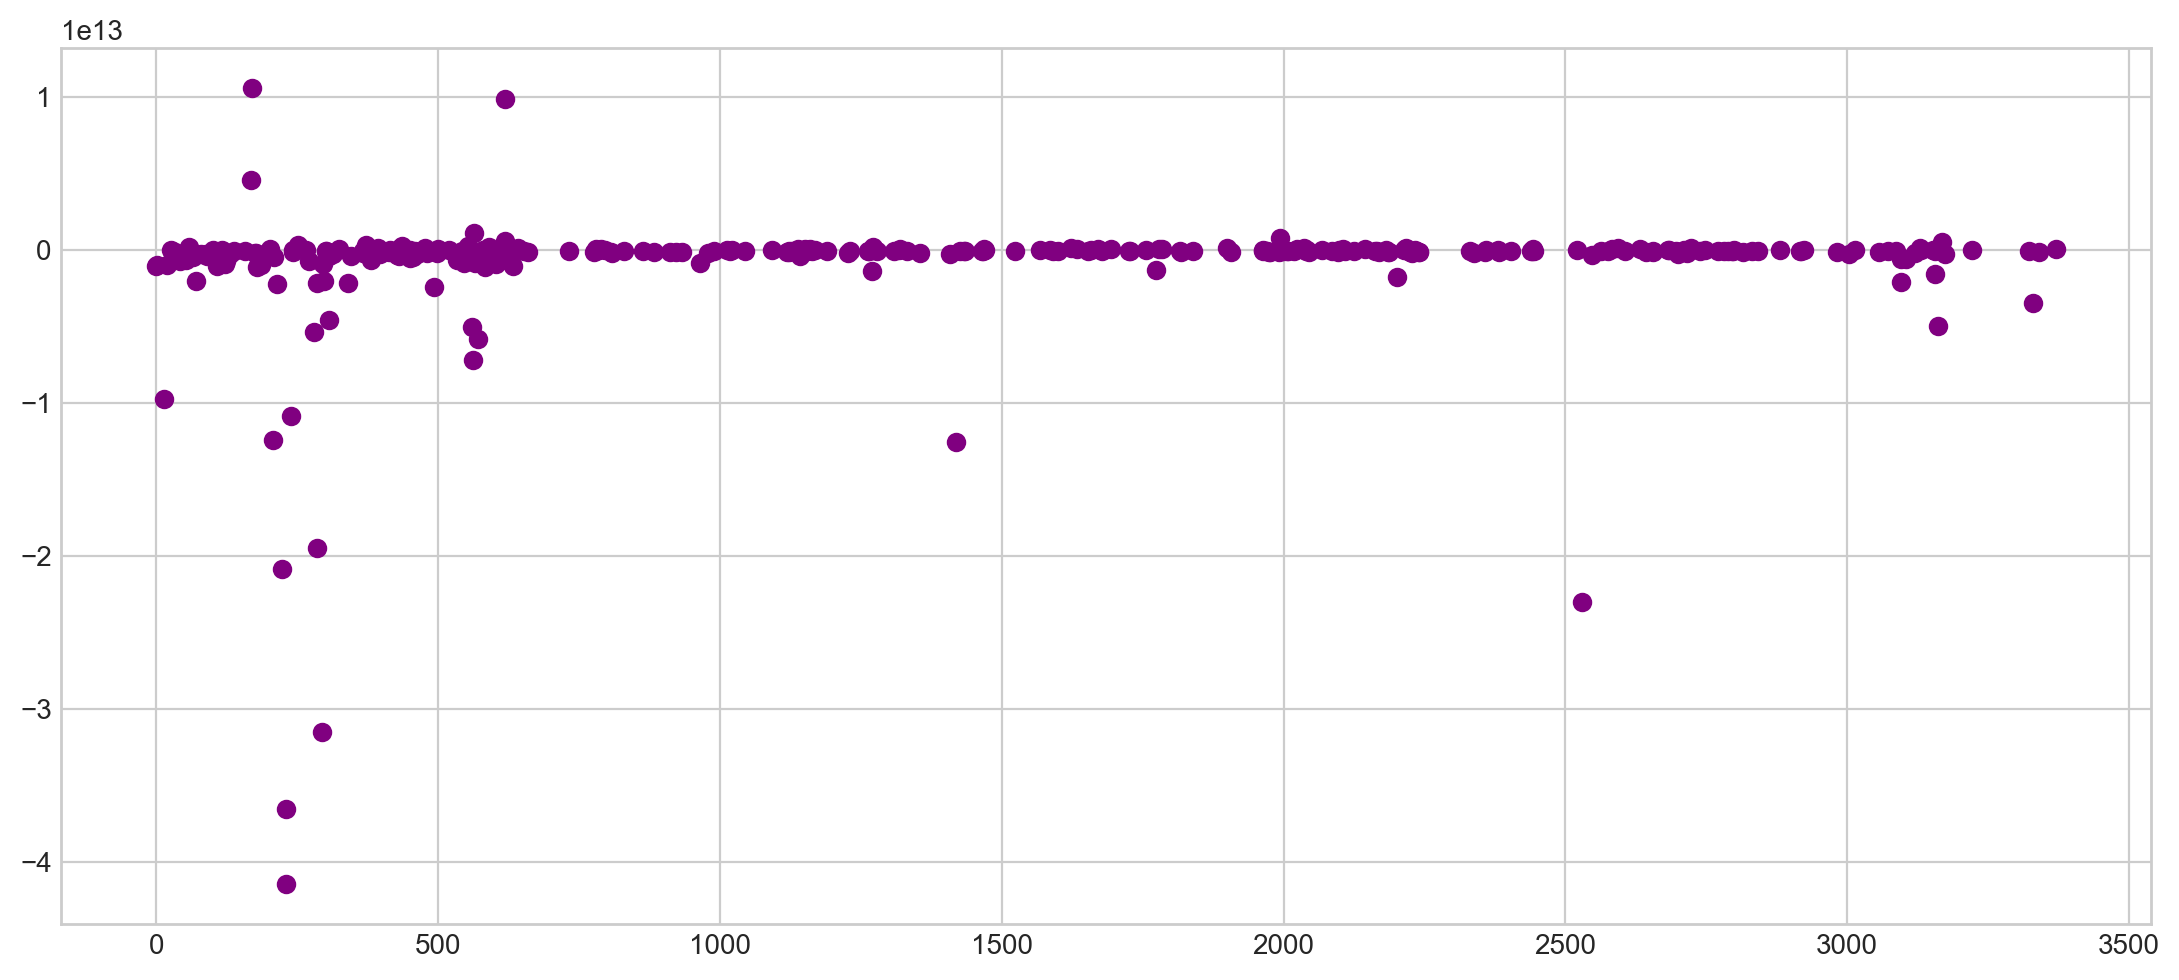

In [179]:
res_energy = pd.DataFrame(y_test_energy)
res_energy['preds'] = final_lr.predict(X_test_energy)
res_energy['diff'] = res_energy.apply(lambda x : x['preds'] - x['SiteEnergyUseWNkBtu'] , axis =1 )
plt.scatter(x = res_energy.index,y = res_energy['diff'], color='purple')